In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown

In [2]:
train_events = pd.read_csv("data/train_events.csv")
train_series = pd.read_parquet("data/train_series.parquet")
train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14510 entries, 0 to 14509
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14510 non-null  object 
 1   night      14510 non-null  int64  
 2   event      14510 non-null  object 
 3   step       9587 non-null   float64
 4   timestamp  9587 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.9+ KB


In [3]:
train_events.head(25)

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
5,038441c925bb,3,wakeup,44400.0,2018-08-17T05:10:00-0400
6,038441c925bb,4,onset,57240.0,2018-08-17T23:00:00-0400
7,038441c925bb,4,wakeup,62856.0,2018-08-18T06:48:00-0400
8,038441c925bb,5,onset,NaN,NaN
9,038441c925bb,5,wakeup,NaN,NaN


In [4]:
train_series.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


We have a lot of NaN values, only 37 series do not have NAN values

In [5]:
series_has_NaN = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())
series_has_NaN.value_counts()
df_has_NaN = series_has_NaN.to_frame()
df_has_NaN.reset_index(inplace=True)

In [6]:
notNaN = df_has_NaN.loc[df_has_NaN.step == False]["series_id"].to_list()
print(f"Number of series that do not contain NaN values: {len(notNaN)}, {notNaN}")

Number of series that do not contain NaN values: 37, ['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a', '3452b878e596', '349c5562ee2c', '3664fe9233f9', '483d6545417f', '55a47ff9dc8a', '5acc9d63b5fd', '5f94bb3e1bed', '655f19eabf1e', '67f5fc60e494', '72bbd1ac3edf', '76237b9406d5', '7822ee8fe3ec', '89bd631d1769', '8e32047cbc1f', '939932f1822d', '9ee455e4770d', 'a596ad0b82aa', 'a9a2f7fac455', 'a9e5f5314bcb', 'af91d9a50547', 'b364205aba43', 'c535634d7dcd', 'c6788e579967', 'c68260cc9e8f', 'ca730dbf521d', 'd150801f3145', 'd25e479ecbb7', 'd515236bdeec', 'd5e47b94477e']


In [7]:
train_events = train_events.dropna()

In [8]:
def get_train_series(train_series, train_events, series):
    current_series = train_series[train_series["series_id"] == series]
    current_events = train_events[train_events["series_id"] == series]

    # cleaning etc.
    current_events = current_events.dropna()
    current_events["step"]  = current_events["step"].astype("int")
    current_events["awake"] = current_events["event"].replace({"onset":1,"wakeup":0})

    train = pd.merge(current_series, current_events[['step','awake']], on='step', how='left')
    train["awake"] = train["awake"].bfill(axis ='rows')
    # final section:
    # train_events.groupby('series_id').tail(1)["event"].unique()
    # Result: the last event is always a "wakeup"
    train['awake'] = train['awake'].fillna(1) # awake
    train["awake"] = train["awake"].astype("int")
    return(train)

series_id     object
step          uint32
timestamp     object
anglez       float32
enmo         float32
awake          int32
dtype: object


###  anglez for series 08db4255286f

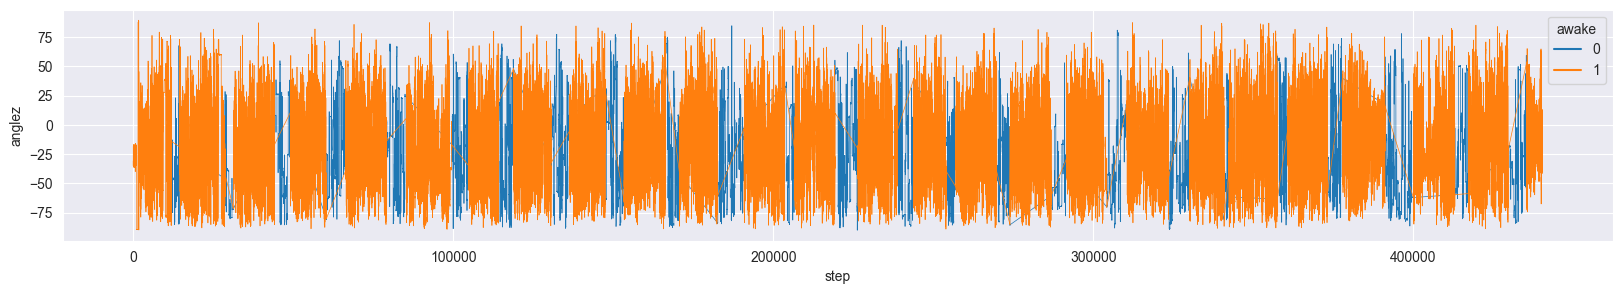

###  enmo for series 08db4255286f

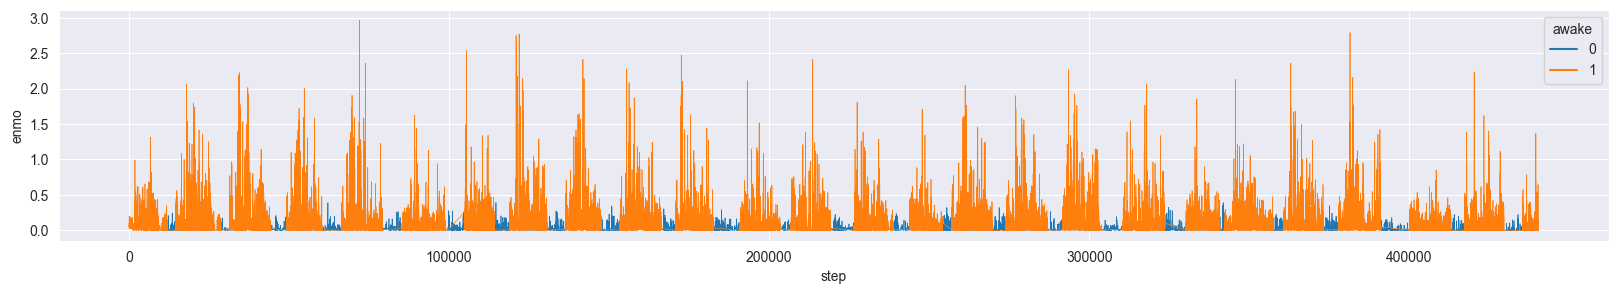

In [9]:
clean_train_data = []

for series_id in notNaN[:1]:
    train = get_train_series(train_series, train_events, series_id)
    print(train.dtypes)
    clean_train_data.append(train)
    
    # vizualize these series
    display(Markdown('###  anglez for series ' + series_id))
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
    plt.show();
    display(Markdown('###  enmo for series ' + series_id))
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=train, x="step", y="enmo",hue="awake", linewidth = 0.5)
    plt.show()
    del train


In [10]:
train_events['date'] = train_events['timestamp'].str.split('T', expand=True)[0]
train_events['time'] = train_events['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
train_events['timestamp'] = pd.to_datetime(train_events['date']+' '+train_events['time'])



In [11]:
train_events['hour'] = train_events['timestamp'].dt.hour.astype(int)
train_events.head()
train_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9587 entries, 0 to 14507
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   series_id  9587 non-null   object        
 1   night      9587 non-null   int64         
 2   event      9587 non-null   object        
 3   step       9587 non-null   float64       
 4   timestamp  9587 non-null   datetime64[ns]
 5   date       9587 non-null   object        
 6   time       9587 non-null   object        
 7   hour       9587 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 636.6+ KB


<Axes: xlabel='hour', ylabel='event'>

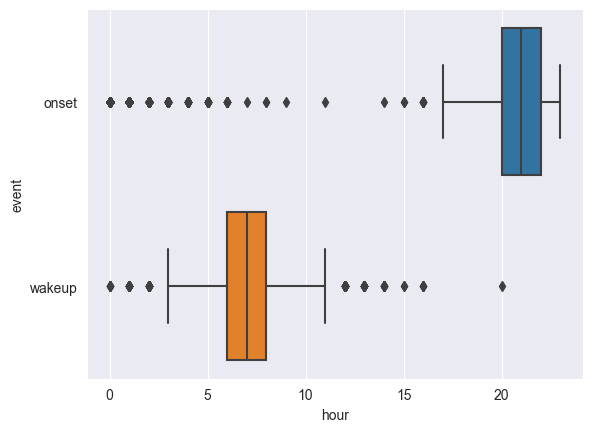

In [12]:
sns.boxplot(data=train_events, x="hour", y="event")

<Axes: xlabel='hour', ylabel='count'>

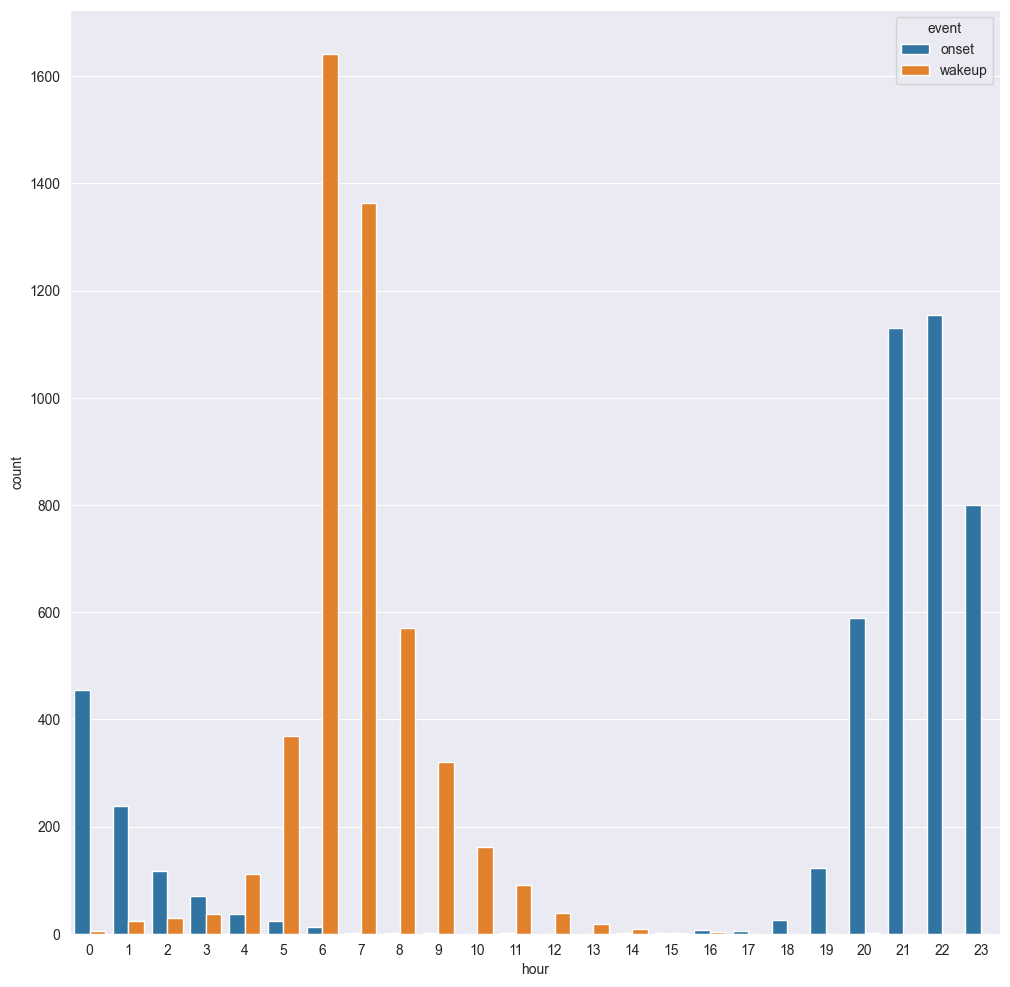

In [13]:
fig, ax = plt.subplots(1,1,figsize=( 12,12))
sns.countplot(data=train_events, x="hour", hue="event")

In [14]:
# train_series["timestamp"] = pd.to_datetime(train_series["timestamp"], utc=True)
# train_series["hour"] = train_series["timestamp"].dt.hour
# train_series["day"] = train_series["timestamp"].dt.day
# train_series.head()

In [15]:
train_events.head()

,series_id,night,event,step,timestamp,date,time,hour
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00,2018-08-14,22:26:00,22
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00,2018-08-15,06:41:00,6
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00,2018-08-15,19:37:00,19
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00,2018-08-16,05:41:00,5
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00,2018-08-16,23:03:00,23


In [16]:
onset_wake_series = train_events.groupby(["series_id", "night"])["event"].value_counts()
onset_wake_series.head()

series_id     night  event 
038441c925bb  1      onset     1
                     wakeup    1
              2      onset     1
                     wakeup    1
              3      onset     1
Name: count, dtype: int64

We can see here that some nights are missing, they have been dropped already in the preprocessing seen above.

In [17]:
onset_wake_series.value_counts()


count
1    9581
2       3
Name: count, dtype: int64

In [18]:
onset_wake_series.value_counts()
onset_wake_series[onset_wake_series == 2]

series_id     night  event
655f19eabf1e  3      onset    2
8a306e0890c0  11     onset    2
c6788e579967  20     onset    2
Name: count, dtype: int64

In [19]:
check_df = train_events[train_events["series_id"] == "655f19eabf1e"]
check_df2 = check_df[check_df["night"] == 3]

check_df2.head()

,series_id,night,event,step,timestamp,date,time,hour
5362,655f19eabf1e,3,onset,43104.0,2017-11-12 01:07:00,2017-11-12,01:07:00,1
5363,655f19eabf1e,3,onset,43824.0,2017-11-12 01:07:00,2017-11-12,01:07:00,1
5364,655f19eabf1e,3,wakeup,48420.0,2017-11-12 07:30:00,2017-11-12,07:30:00,7


In [20]:
check_df = train_events[train_events["series_id"] == "655f19eabf1e"]

check_df.head(50)

,series_id,night,event,step,timestamp,date,time,hour
5358,655f19eabf1e,1,onset,6456.0,2017-11-09 22:13:00,2017-11-09,22:13:00,22
5359,655f19eabf1e,1,wakeup,12696.0,2017-11-10 06:53:00,2017-11-10,06:53:00,6
5360,655f19eabf1e,2,onset,25032.0,2017-11-11 00:01:00,2017-11-11,00:01:00,0
5361,655f19eabf1e,2,wakeup,29880.0,2017-11-11 06:45:00,2017-11-11,06:45:00,6
5362,655f19eabf1e,3,onset,43104.0,2017-11-12 01:07:00,2017-11-12,01:07:00,1
5363,655f19eabf1e,3,onset,43824.0,2017-11-12 01:07:00,2017-11-12,01:07:00,1
5364,655f19eabf1e,3,wakeup,48420.0,2017-11-12 07:30:00,2017-11-12,07:30:00,7
5365,655f19eabf1e,4,onset,58212.0,2017-11-12 21:06:00,2017-11-12,21:06:00,21
5366,655f19eabf1e,4,wakeup,65076.0,2017-11-13 06:38:00,2017-11-13,06:38:00,6
5367,655f19eabf1e,5,onset,75852.0,2017-11-13 21:36:00,2017-11-13,21:36:00,21


In [21]:
check_df = train_events[train_events["series_id"] == "8a306e0890c0"]
check_df2 = check_df[check_df["night"] == 11]

check_df2.head()

,series_id,night,event,step,timestamp,date,time,hour
7357,8a306e0890c0,11,onset,178464.0,2017-11-12 01:37:00,2017-11-12,01:37:00,1
7358,8a306e0890c0,11,onset,179184.0,2017-11-12 01:37:00,2017-11-12,01:37:00,1
7359,8a306e0890c0,11,wakeup,184536.0,2017-11-12 09:03:00,2017-11-12,09:03:00,9


In [22]:
check_df = train_events[train_events["series_id"] == "c6788e579967"]
check_df2 = check_df[check_df["night"] == 20]

check_df2.head()

,series_id,night,event,step,timestamp,date,time,hour
10349,c6788e579967,20,onset,333552.0,2018-11-11 01:16:00,2018-11-11,01:16:00,1
10350,c6788e579967,20,onset,334272.0,2018-11-11 01:16:00,2018-11-11,01:16:00,1
10351,c6788e579967,20,wakeup,340404.0,2018-11-11 09:47:00,2018-11-11,09:47:00,9


Very interesting observations we can see here above, there are 2 onsets and 1 wakeup in a night where the onsets are at different steps but at the same timestamp! This seems to be a data error, and these duplicate wrong rows should eventually be reviewed. 

Future research:

How to deal with NaN values in the events dataset?
Calculate Average sleep duration (difference onset - go to bed)
Check how many nights there are in 24 hours (histogram plot)
We have to count how many nights there are in a day. (Could there be multiple by their definition of night?)


NANs can be caused by:
    - No watch worn during the night
    - No valid sleep window identified
    
Important
    - < 30 minutes of activity during sleep does not induce wakeup!
    - nights are determined by onset + wakeup of the person. Not on the daytime
    - Only longest sleep window is recorded every night
    
